In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import vtk
from dataloading import loader
from vtk.util import numpy_support
from vedo import Mesh, Plotter, show, settings, Points, Point, Plane
import os
import numpy as np
import pandas as pd
import miniball
from typing import List
from processing import meshes as meshes_processing
from training.datagenerator import DataGenerator
from models import pointnet_seg
from training.processer import Processer


2023-08-08 00:07:23.950792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 00:07:23.988365: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 00:07:23.989283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 00:07:24.598594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
with open("data/labels.json", "r") as f:
    tooth_label_dict = json.load(f)

with open("data/Teeth3DS_train_test_split/testing_lower.txt", "r") as f:
    test_ex = f.read().splitlines()

LOWER_PATH = "data/lower"
folders = os.listdir(LOWER_PATH)

test_obj_files = [
    os.path.join(LOWER_PATH, f, f"{f}_lower.obj")
    for f in folders
    if f"{f}_lower" in test_ex
]
test_label_files = [
    os.path.join(LOWER_PATH, f, f"{f}_lower.json")
    for f in folders
    if f"{f}_lower" in test_ex
]

Open a random example and its labels

In [4]:
index_to_check = 3
obj_file = test_obj_files[0]
polydata = loader.read_obj(obj_file)

label_file = test_label_files[0]
with open(label_file, "r") as f:
    labels = json.load(f)["labels"]

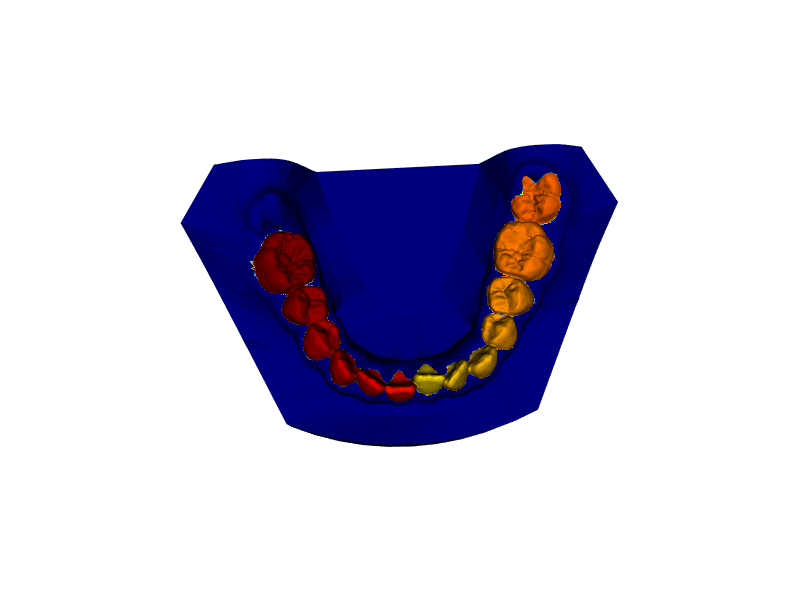

In [5]:
vedo_mesh = Mesh(polydata)
vedo_mesh.cmap("jet", labels, on="points")
show(vedo_mesh)

Highlight the LeftMandibularSecondMolar

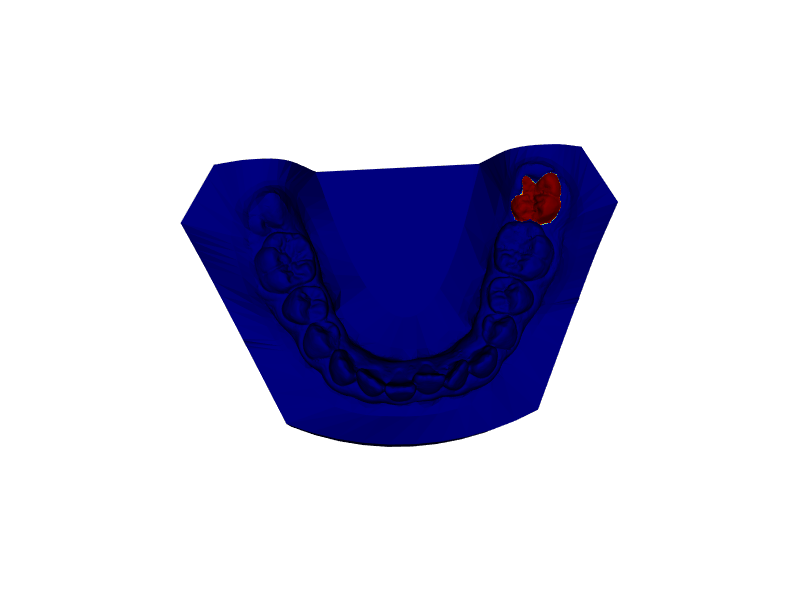

In [6]:
label_to_remove = tooth_label_dict["LeftMandibularSecondMolar"]
label = labels
label = np.zeros(np.array(labels).shape)
labels = np.array(labels).astype(int)
label[labels == label_to_remove] = 1

# Add the objects to the plotter
# Convert the VTK PolyData to a vedo Mesh
vedo_mesh = Mesh(polydata)
vedo_mesh.cmap("jet", label, on="points")

# Show the plot
show(vedo_mesh)

Create a sphere with the size of the tooth

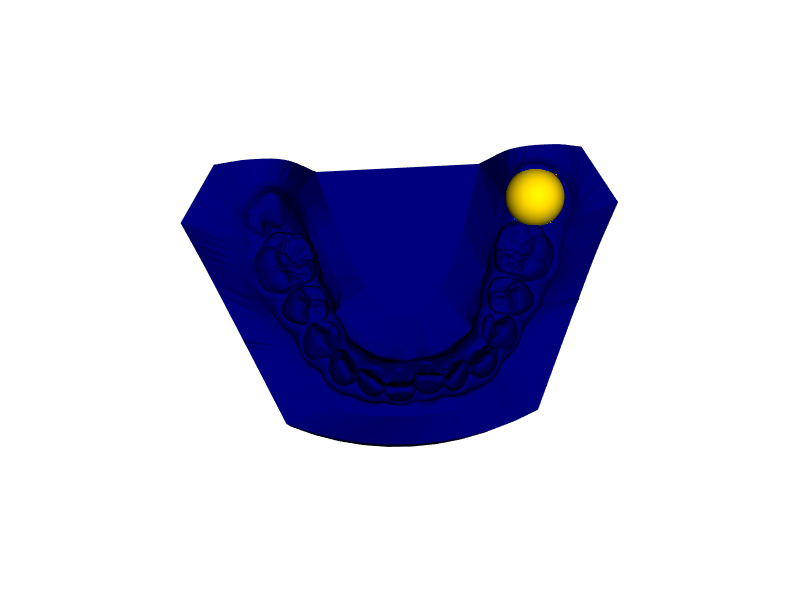

In [7]:
polydata_points = numpy_support.vtk_to_numpy(polydata.GetPoints().GetData())
tooth_to_extract = polydata_points[label == 1]
tooth_df = pd.DataFrame(tooth_to_extract, columns=["x", "y", "z"])
sphere_center, sphere_radius = miniball.get_bounding_ball(tooth_df.values)

sphere_source = meshes_processing.define_sphere_source(sphere_center, sphere_radius / 6)
sphere_polydata = sphere_source.GetOutput()
Plotter()
# Create a PointCloud object
point_cloud = Points(tooth_to_extract)
vedo_sphere = Mesh(sphere_polydata)

# Show the point cloud
show(vedo_sphere, vedo_mesh)

Remove the tooth using a box

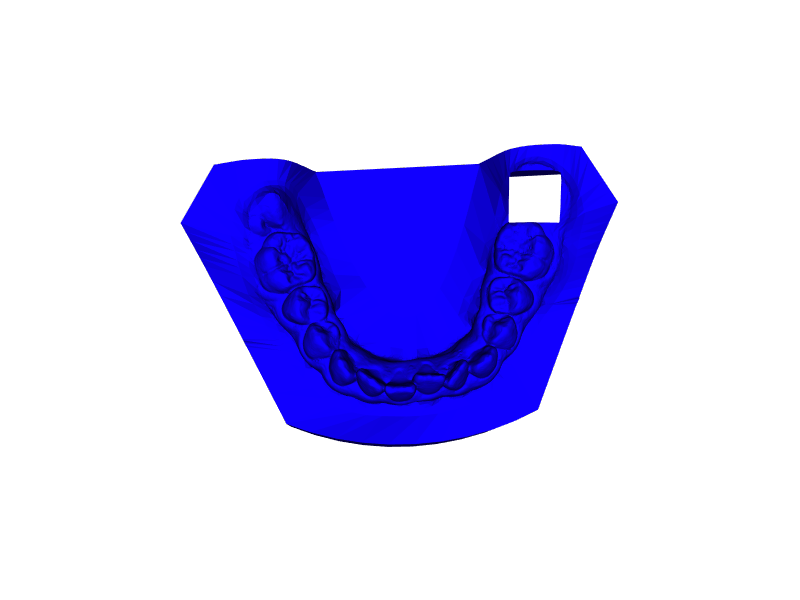

In [8]:
plane = meshes_processing.define_plane(sphere_center, [0, 0, 1])

plane_vedo = Plane(sphere_center, normal=(0, 0, 1), s=(10, 10))

bounds = [
    sphere_center[0] - 5,
    sphere_center[0] + 5,
    sphere_center[1] - 5,
    sphere_center[1] + 5,
    sphere_center[2] - 5,
    sphere_center[2] + 5,
]

cut_polydata = meshes_processing.cut_by_bounds(polydata, bounds)
cut_vedo_mesh = Mesh(cut_polydata, "blue")
Plotter()
show(cut_vedo_mesh)

Predicting with the trained model

In [10]:
num_classes = 1
num_points = 10000

# Process Data
df = pd.DataFrame({"obj_file": [obj_file], "label_file": [label_file]})
label_to_remove = tooth_label_dict["LeftMandibularSecondMolar"]
processer = Processer([label_to_remove])
processed_df = processer.preprocessing(df)

generator = DataGenerator(
    processed_df["obj_file"].values,
    processed_df["labels_of_interest"].values,
    num_classes=num_classes,
)

model = pointnet_seg.get_shape_segmentation_model(num_points, num_classes=num_classes+1)
model.load_weights("data/tmp/models/21_11_42_07_08_2023/").expect_partial()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

ex=generator[0]
prediction = model.predict(ex[0])


2023-08-08 00:08:04.197270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-08 00:08:04.197755: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


data/lower/01E9V1EX/01E9V1EX_lower.obj
1/1 [==============================] - 1s 600ms/step


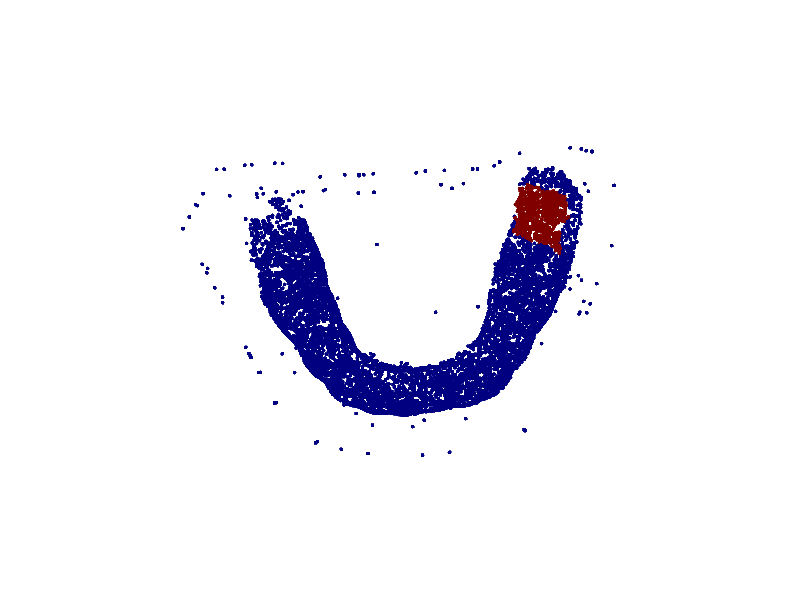

In [11]:
pred = np.argmax(prediction, axis=-1)[0]

point_cloud = Points(ex[0][0])
point_cloud.cmap("jet", pred)
# Show the plot
Plotter()
show(point_cloud)

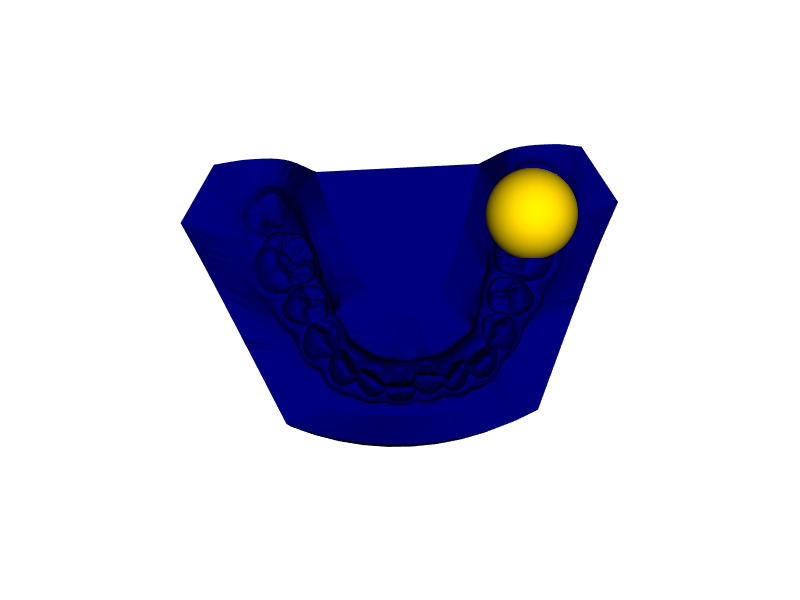

In [12]:
polydata_points = ex[0][0]
tooth_predicted_points = polydata_points[pred==1]
sphere_center, sphere_radius = miniball.get_bounding_ball(tooth_predicted_points)
sphere_source = meshes_processing.define_sphere_source(sphere_center, sphere_radius / 6)
sphere_polydata = sphere_source.GetOutput()
Plotter()
# Create a PointCloud object
vedo_sphere = Mesh(sphere_polydata)

# Show the point cloud
show(vedo_sphere, vedo_mesh)

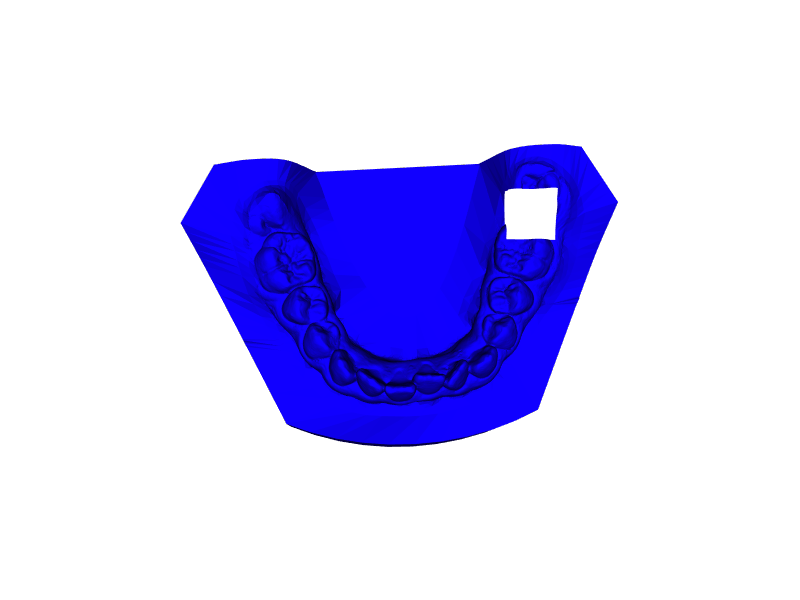

In [13]:
plane = meshes_processing.define_plane(sphere_center, [0, 0, 1])

plane_vedo = Plane(sphere_center, normal=(0, 0, 1), s=(10, 10))

bounds = [
    sphere_center[0] - 5,
    sphere_center[0] + 5,
    sphere_center[1] - 5,
    sphere_center[1] + 5,
    sphere_center[2] - 5,
    sphere_center[2] + 5,
]

cut_polydata = meshes_processing.cut_by_bounds(polydata, bounds)
cut_vedo_mesh = Mesh(cut_polydata, "blue")
Plotter()
show(cut_vedo_mesh)